In [3]:
validated_df = pd.read_csv('./large-corpus/validated.tsv', sep='\t')

/tmp/ipykernel_3060337/497813418.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  validated_df = pd.read_csv('./large-corpus/validated.tsv', sep='\t')


In [131]:
validated_df.head()

,client_id,path,sentence_id,sentence,sentence_domain,up_votes,down_votes,age,gender,accents,variant,locale,segment
0,0294d9751511843184ab839d1837ab7a41a98348766864...,common_voice_zh-CN_33411896.mp3,fc88f495ef25b785e3fbc0c56d95a74761d3ae1da57855...,黑身准裂腹鱼为辐鳍鱼纲鲤形目鲤科的其中一种。,NaN,2,0,NaN,NaN,NaN,NaN,zh-CN,NaN
1,02bf7ccb5f078eb0294cc22f6d725720e4079d0190fa81...,common_voice_zh-CN_32269533.mp3,8c25ebbacc7b9fcfcca3c1d22acba9181ce38edf00502d...,否,NaN,2,1,NaN,NaN,NaN,NaN,zh-CN,Benchmark
2,02ec74191c6ccc7dcf6ecaa217268263c477273b4de93f...,common_voice_zh-CN_22069600.mp3,73f88858e2402cca1896ec78186d8db1a7f5e66221fc7f...,宋朝末年年间定居粉岭围。,NaN,2,0,NaN,NaN,NaN,NaN,zh-CN,NaN
3,039d72bf7503fe0261157341a5ba4bd017b6b5f000338b...,common_voice_zh-CN_33446629.mp3,6a904363f29a6351d8ebb35fa72c6c7ca1d6fa7964ca41...,油小路通是京都市主要的南北向道路之一。,NaN,2,0,NaN,NaN,NaN,NaN,zh-CN,NaN
4,03f39c4095d773278747e6ab5e591484fb8cb133c7945c...,common_voice_zh-CN_33615736.mp3,6a7f9a3a395f067bbc63d6263ca7a3ab1b8a7cdb5f5063...,富尔马诺夫出生在科斯特罗马省谢列达的一个农民家庭。,NaN,2,0,NaN,NaN,NaN,NaN,zh-CN,NaN


In [176]:
def breakdown_pinyin_v_to_u(phrase):
  clean_phrase = re.sub(r'[^\w]', '', phrase)
  initial = lazy_pinyin(clean_phrase, style=Style.INITIALS, strict=True)
  final = lazy_pinyin(clean_phrase, style=Style.FINALS, strict=True)
  tone = [ word[-1] for word in lazy_pinyin(clean_phrase, style=Style.FINALS_TONE3, strict=False, v_to_u=True, neutral_tone_with_five=True, tone_sandhi=True)]
  
  initial = [init if init != '' else "EMPTY" for init in initial ]

  return list(zip(initial, final, tone))

In [178]:
myDF = validated_df.copy()
myDF['pinyin_breakdown'] = myDF['sentence'].progress_apply(breakdown_pinyin_v_to_u)
myDF['words'] = myDF['sentence'].apply(lambda row: [char for char in re.sub(r'[^\w]', '', row)])

Processing data: 100%|██████████| 187414/187414 [01:30<00:00, 2074.27it/s]


In [179]:
mask = myDF.apply(lambda row: len(row['words']) == len(row['pinyin_breakdown']), axis=1)

In [182]:
filtered_myDF = myDF[mask]

In [183]:
better = filtered_myDF.explode(['words', 'pinyin_breakdown'])

In [184]:
better[['initial', 'final', 'tone']] = pd.DataFrame(better['pinyin_breakdown'].tolist(), index=better.index)

In [170]:
s = validated_df['sentence'].progress_apply(lambda row: lazy_pinyin(row))

Processing data: 100%|██████████| 187414/187414 [00:15<00:00, 12048.97it/s]


In [175]:
s

0         [hei, shen, zhun, lie, fu, yu, wei, fu, qi, yu...
1                                                     [fou]
2         [song, chao, mo, nian, nian, jian, ding, ju, f...
3         [you, xiao, lu, tong, shi, jing, du, shi, zhu,...
4         [fu, er, ma, nuo, fu, chu, sheng, zai, ke, si,...
                                ...                        
187409    [zhe, bei, gong, he, pai, he, she, hui, zhu, y...
187410    [han, mo, shi, mi, si, shi, lun, dun, de, yi, ...
187411    [bei, chu, li, de, jing, pian, shi, yang, fang...
187412    [ceng, lian, huo, san, jie, guo, jia, xin, wen...
187413                   [gu, xi, la, zuo, jia, zhi, yi, 。]
Name: sentence, Length: 187414, dtype: object

In [173]:
len(s)

187414

In [172]:
sum(s.apply(lambda x: len(x)))

2700140

In [ ]:
import matplotlib.pyplot as plt
audio_files = validated_df['path'].apply(lambda x: LARGE_16K_DIR / x).to_list()
energies = tqdm([librosa.feature.rms(y=torchaudio.load(f)[0].numpy().squeeze()).mean() for f in tqdm(audio_files)])
plt.hist(energies, bins=50)
plt.show()


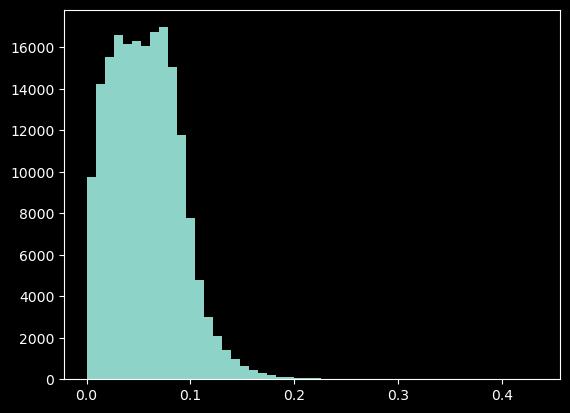

In [146]:
import matplotlib.pyplot as plt
audio_files = validated_df['path'].apply(lambda x: LARGE_16K_DIR / x).to_list()
energies = [librosa.feature.rms(y=torchaudio.load(f)[0].numpy().squeeze()).mean() for f in audio_files]
plt.hist(energies, bins=50)
plt.show()


In [4]:
voice = 'common_voice_zh-CN_32892241.mp3'
print(f"sentence: {validated_df[validated_df['path'] == voice]['sentence'].iloc[0] }")
waveform16k, sample_rate = torchaudio.load(LARGE_16K_DIR / voice)
IPython.display.Audio(waveform16k, rate=16000)


sentence: 永宗大桥是座位于韩国仁川广域市连接永宗岛于朝鲜半岛内陆的自锚式悬索桥。


In [3]:
new_df = pd.read_csv('./large-corpus/prepped.csv')

In [9]:
new_df['transcript'] = new_df['transcript'].apply(json.loads)

In [12]:
new_df['transcript'] = new_df['transcript'].apply(lambda row: ' '.join(row))

In [14]:
new_df['sentence'] = new_df['sentence'].apply(lambda row: re.sub(r'[^\w]', '', row))

In [5]:
new_df.shape

(600247, 7)

In [16]:
new_df['transcript'][0]

'mo shi zhong cai yang zi tai wan gui shan dao'

In [17]:
long = new_df[new_df['path'] == 'common_voice_zh-CN_32554902.mp3']

In [18]:
long

,Unnamed: 0,path,transcript,sentence,age,gender,accents
60105,60105,common_voice_zh-CN_32554902.mp3,ren ren you quan xiang shou wei wei chi ta ben...,人人有权享受为维持他本人和家属的健康和福利所需的生活水准包括食物衣着住房医疗和必要的社会服务...,NaN,NaN,NaN


In [19]:
print(lazy_pinyin(long['sentence']))

['ren', 'ren', 'you', 'quan', 'xiang', 'shou', 'wei', 'wei', 'chi', 'ta', 'ben', 'ren', 'he', 'jia', 'shu', 'de', 'jian', 'kang', 'he', 'fu', 'li', 'suo', 'xu', 'de', 'sheng', 'huo', 'shui', 'zhun', 'bao', 'kuo', 'shi', 'wu', 'yi', 'zhe', 'zhu', 'fang', 'yi', 'liao', 'he', 'bi', 'yao', 'de', 'she', 'hui', 'fu', 'wu', 'zai', 'zao', 'dao', 'shi', 'ye', 'ji', 'bing', 'can', 'fei', 'shou', 'gua', 'shuai', 'lao', 'huo', 'zai', 'qi', 'ta', 'bu', 'neng', 'kong', 'zhi', 'de', 'qing', 'kuang', 'xia', 'sang', 'shi', 'mou', 'sheng', 'neng', 'li', 'shi', 'you', 'quan', 'xiang', 'shou', 'bao', 'zhang']


In [22]:
params = new_df[['path', 'transcript', 'sentence']].to_records(index=False).tolist()

In [147]:
import sys


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = bundle.get_model().to(device)
tokenizer = bundle.get_tokenizer()
aligner = bundle.get_aligner()

# ------------------------------------------------ #

def compute_alignments(waveform: torch.Tensor, transcript: List[str]):
  with torch.inference_mode():
    emission, _ = model(waveform.to(device))
    token_spans = aligner(emission[0], tokenizer(transcript))
  return emission, token_spans

def get_words(waveform, spans, num_frames):
  ratio = waveform.size(1) / num_frames

  return [
    waveform[:, int(ratio * span[0].start) : int(ratio * span[-1].end)]
    for span in spans
  ]

def driver(args):
  path, transcript, sentence = args

  try:
    waveform16k, _ = torchaudio.load(LARGE_16K_DIR / path)
    waveform16k = waveform16k[0:1].to(device)

    emission, token_spans = compute_alignments(waveform16k, transcript)
    num_frames = emission.size(1)

    words = get_words(waveform16k, token_spans, num_frames)

    # save each word tensor and store filenames
    word_filenames = []
    for i, word in enumerate(words):
      filename = f"{Path(path).stem}_word{i}.pt"
      filepath = WORD_TENSORS_DIR / filename
      torch.save(word.cpu(), filepath)
      word_filenames.append(str(filepath))

    return word_filenames, sentence

  except Exception as e:
    if "targets length is too long for CTC" in str(e):
      error_message = f"Alignment failed for {path}: {e}\n"
      sys.stderr.write(error_message)  # Print to stderr to avoid tqdm interference
      sys.stderr.flush()  # Ensure immediate writing to stderr

    else:
      sys.stderr.write(f"something else went wrong: {e}")  # Print to stderr to avoid tqdm interference
      sys.stderr.flush()  # Ensure immediate writing to stderr

    return None  # Ensures the pipeline doesn’t crash

In [148]:
small_val = validated_df[0:300]

In [150]:
small_val['sentence'] = small_val['sentence'].apply(lambda row: re.sub(r'[^\w]', '', row)) 

valid_pinyin = set("abcdefghijklmnopqrstuvwxyz")  # Allowed characters

def clean_pinyin(pinyin_list):
  return [''.join(c for c in word if c in valid_pinyin) for word in pinyin_list]

small_val['transcript'] = small_val['sentence'].apply(lambda row: clean_pinyin(lazy_pinyin(row)))


params_small = small_val[['path', 'transcript', 'sentence']].to_records(index=False).tolist()

/tmp/ipykernel_3032636/3586386153.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_val['sentence'] = small_val['sentence'].apply(lambda row: re.sub(r'[^\w]', '', row))
/tmp/ipykernel_3032636/3586386153.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_val['transcript'] = small_val['sentence'].apply(lambda row: clean_pinyin(lazy_pinyin(row)))


In [151]:
segmentations = [driver(param) for param in tqdm(params_small) ]

100%|██████████| 300/300 [00:15<00:00, 19.50it/s]


In [ ]:
segmentations = [s for s in segmentations if s is not None]

In [166]:
test = pd.DataFrame(segmentations, columns=['word_files', 'sentence'])



In [167]:
test['transcript'] = test['sentence'].apply(lambda row: clean_pinyin(lazy_pinyin(row)))

In [188]:
test

,word_files,sentence,transcript
0,[/home/connor/audio/data/word_tensors/common_v...,黑身准裂腹鱼为辐鳍鱼纲鲤形目鲤科的其中一种,"[hei, shen, zhun, lie, fu, yu, wei, fu, qi, yu..."
1,[/home/connor/audio/data/word_tensors/common_v...,否,[fou]
2,[/home/connor/audio/data/word_tensors/common_v...,宋朝末年年间定居粉岭围,"[song, chao, mo, nian, nian, jian, ding, ju, f..."
3,[/home/connor/audio/data/word_tensors/common_v...,油小路通是京都市主要的南北向道路之一,"[you, xiao, lu, tong, shi, jing, du, shi, zhu,..."
4,[/home/connor/audio/data/word_tensors/common_v...,富尔马诺夫出生在科斯特罗马省谢列达的一个农民家庭,"[fu, er, ma, nuo, fu, chu, sheng, zai, ke, si,..."
...,...,...,...
294,[/home/connor/audio/data/word_tensors/common_v...,三,[san]
295,[/home/connor/audio/data/word_tensors/common_v...,拉瓦莱特人口变化图示,"[la, wa, lai, te, ren, kou, bian, hua, tu, shi]"
296,[/home/connor/audio/data/word_tensors/common_v...,这么閒还不快点去浪费时间,"[zhe, me, xian, hai, bu, kuai, dian, qu, lang,..."
297,[/home/connor/audio/data/word_tensors/common_v...,七,[qi]


In [169]:
test.explode(['word_files', 'transcript'])

,word_files,sentence,transcript
0,/home/connor/audio/data/word_tensors/common_vo...,黑身准裂腹鱼为辐鳍鱼纲鲤形目鲤科的其中一种,hei
0,/home/connor/audio/data/word_tensors/common_vo...,黑身准裂腹鱼为辐鳍鱼纲鲤形目鲤科的其中一种,shen
0,/home/connor/audio/data/word_tensors/common_vo...,黑身准裂腹鱼为辐鳍鱼纲鲤形目鲤科的其中一种,zhun
0,/home/connor/audio/data/word_tensors/common_vo...,黑身准裂腹鱼为辐鳍鱼纲鲤形目鲤科的其中一种,lie
0,/home/connor/audio/data/word_tensors/common_vo...,黑身准裂腹鱼为辐鳍鱼纲鲤形目鲤科的其中一种,fu
...,...,...,...
298,/home/connor/audio/data/word_tensors/common_vo...,埃尔特尔莱因是德国萨克森州的一个市镇,de
298,/home/connor/audio/data/word_tensors/common_vo...,埃尔特尔莱因是德国萨克森州的一个市镇,yi
298,/home/connor/audio/data/word_tensors/common_vo...,埃尔特尔莱因是德国萨克森州的一个市镇,ge
298,/home/connor/audio/data/word_tensors/common_vo...,埃尔特尔莱因是德国萨克森州的一个市镇,shi


In [ ]:
metadata_df = pd.DataFrame(segmentations, columns=['word_files', 'sentence'])


In [24]:
assert len(metadata_df['word_files'][0]) == len(lazy_pinyin(metadata_df['sentence'][0]))

In [12]:
sentences[:10]

('模式种采样自台湾龟山岛',
 '后者娶天之瓮主神',
 '贝尔卢',
 '日本与东帝汶的关系可追溯至第二次世界大战期间',
 '单县各乡镇设有卫生院或医院',
 '尤里二世当下便决定要在该地点建造大基捷日城',
 '毛山鼠李为鼠李科鼠李属下的一个变种',
 '遂吸收众多渴望消灾除难的人入道',
 '毛山鼠李为鼠李科鼠李属下的一个变种',
 '这项研究旨在了解一个地区的空间结构和性质')

# --------------------

In [26]:
df = pd.read_csv('./large-corpus/other.tsv', sep='\t')

/tmp/ipykernel_3032636/749438795.py:1: DtypeWarning: Columns (4,8,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./large-corpus/other.tsv', sep='\t')


In [27]:
df = df[['path', 'sentence', 'age', 'gender', 'accents']]

In [28]:
df.tail(10)

,path,sentence,age,gender,accents
600237,common_voice_zh-CN_41891242.mp3,它是西半球最大的科学博物馆。,thirties,NaN,出生地：51 四川省
600238,common_voice_zh-CN_41891243.mp3,总的来说，美国从政策和制度上在乌克兰开展反对俄罗斯的活动包括经济援助、军事援助、外交压力、信...,thirties,NaN,出生地：51 四川省
600239,common_voice_zh-CN_41891244.mp3,智深道：“胡说，这等一个大去处，不信没斋粮。,thirties,NaN,出生地：51 四川省
600240,common_voice_zh-CN_41891245.mp3,輕輕敲醒沉睡的心靈，慢慢張開你地眼睛,thirties,NaN,出生地：51 四川省
600241,common_voice_zh-CN_41891246.mp3,中华民国主权属于国民全体,thirties,NaN,出生地：51 四川省
600242,common_voice_zh-CN_41891247.mp3,炫家军来也！,thirties,NaN,出生地：51 四川省
600243,common_voice_zh-CN_41891248.mp3,索伊贝尔斯多尔夫是德国巴伐利亚州的一个市镇。,thirties,NaN,出生地：51 四川省
600244,common_voice_zh-CN_41891249.mp3,情报侦察：乌克兰军队通过加强情报侦察工作，及时获得敌方无人机的动向和部署情况，从而能够提前采...,thirties,NaN,出生地：51 四川省
600245,common_voice_zh-CN_41907107.mp3,三,NaN,NaN,NaN
600246,common_voice_zh-CN_41907108.mp3,数据集包含真实、仿真和干净的录音。,NaN,NaN,NaN


In [29]:
df['sentence'] = df['sentence'].apply(lambda row: re.sub(r'[^\w]', '', row)) 

In [35]:
df['transcript'] = df['sentence'].progress_apply(lambda row: [ "".join(lazy_pinyin(word)) for word in list(jieba.cut(row))])

Processing data: 100%|██████████| 600247/600247 [01:34<00:00, 6358.20it/s]


In [40]:
df['transcript'][0:5]

0      [moshi, zhong, caiyang, zi, taiwan, guishandao]
1               [houzhe, qu, tian, zhi, weng, zhushen]
2                                          [beier, lu]
3    [riben, yu, dongdiwen, de, guanxi, kezhuisu, z...
4    [danxian, gexiangzhen, sheyou, weishengyuan, h...
Name: transcript, dtype: object

In [41]:
long = df[df['path'] == 'common_voice_zh-CN_32554902.mp3']

241227    三甲村战斗是发生在中国抗日战争百团大战期间涞灵战役中的一次战斗
Name: sentence, dtype: object

In [133]:
voice = 'common_voice_zh-CN_33411896.mp3'
print(f"sentence: {validated_df[validated_df['path'] == voice]['sentence'].iloc[0] }")
waveform16k, sample_rate = torchaudio.load(LARGE_16K_DIR / voice)
IPython.display.Audio(waveform16k, rate=16000)


sentence: 黑身准裂腹鱼为辐鳍鱼纲鲤形目鲤科的其中一种。


In [ ]:
torchaudio.load(LARGE_16K_DIR / df['path'][0])

(tensor([[-1.1826e-05, -3.8991e-05, -1.4978e-05,  ..., -1.4315e-04,
          -1.3605e-05,  2.1167e-05]]),
 16000)

In [42]:
device = 'cuda'

In [76]:

model = bundle.get_model(with_star=True)
model.to(device)

tokenizer = bundle.get_tokenizer()
aligner = bundle.get_aligner()


In [77]:
def compute_alignments(waveform: torch.Tensor, transcript: List[str]):
    with torch.inference_mode():
        emission, _ = model(waveform.to(device))
        token_spans = aligner(emission[0], tokenizer(transcript))
    return emission, token_spans


In [78]:
# Compute average score weighted by the span length
def _score(spans):
    return sum(s.score * len(s) for s in spans) / sum(len(s) for s in spans)


def plot_alignments(waveform, token_spans, emission, transcript, sample_rate=bundle.sample_rate):
    ratio = waveform.size(1) / emission.size(1) / sample_rate

    fig, axes = plt.subplots(2, 1)
    axes[0].imshow(emission[0].detach().cpu().T, aspect="auto")
    axes[0].set_title("Emission")
    axes[0].set_xticks([])

    axes[1].specgram(waveform[0], Fs=sample_rate)
    for t_spans, chars in zip(token_spans, transcript):
        t0, t1 = t_spans[0].start, t_spans[-1].end
        axes[0].axvspan(t0 - 0.5, t1 - 0.5, facecolor="None", hatch="/", edgecolor="white")
        axes[1].axvspan(ratio * t0, ratio * t1, facecolor="None", hatch="/", edgecolor="white")
        axes[1].annotate(f"{_score(t_spans):.2f}", (ratio * t0, sample_rate * 0.51), annotation_clip=False)

        for span, char in zip(t_spans, chars):
            t0 = span.start * ratio
            axes[1].annotate(char, (t0, sample_rate * 0.55), annotation_clip=False)

    axes[1].set_xlabel("time [second]")
    fig.tight_layout()


In [79]:
def preview_word(waveform, spans, num_frames, transcript, sample_rate=bundle.sample_rate):
    ratio = waveform.size(1) / num_frames
    x0 = int(ratio * spans[0].start)
    x1 = int(ratio * spans[-1].end)
    print(f"{transcript} ({_score(spans):.2f}): {x0 / sample_rate:.3f} - {x1 / sample_rate:.3f} sec")
    segment = waveform[:, x0:x1]
    return IPython.display.Audio(segment.numpy(), rate=sample_rate)


In [80]:
long['sentence'].to_string(index=False)

'人人有权享受为维持他本人和家属的健康和福利所需的生活水准包括食物衣着住房医疗和必要的社会服务在...'

In [81]:
raw_text = re.sub(r'[^\w]', '', long['sentence'].to_string(index=False))

In [82]:
transcript = lazy_pinyin(raw_text)

In [13]:
waveform16k, sample_rate = torchaudio.load(LARGE_16K_DIR / df['path'][0])

In [55]:
waveform16k_long, sample_rate = torchaudio.load(LARGE_16K_DIR / long['path'].to_string(index=False))

In [83]:
transcript = long['transcript'].iloc[0]

In [84]:
len(transcript)

49

In [73]:
sum([ len(item) for item in tokenizer(transcript)])

261

In [101]:
transcript

['renren',
 'youquan',
 'xiangshou',
 'wei',
 'weichi',
 'ta',
 'benren',
 'he',
 'jiashu',
 'de',
 'jiankang',
 'he',
 'fuli',
 'suo',
 'xu',
 'de',
 'shenghuoshuizhun',
 'baokuo',
 'shiwu',
 'yizhuo',
 'zhufang',
 'yiliao',
 'he',
 'biyao',
 'de',
 'shehui',
 'fuwu',
 'zai',
 'zaodao',
 'shiye',
 'jibing',
 'canfei',
 'shougua',
 'shuailao',
 'huo',
 'zai',
 'qita',
 'buneng',
 'kongzhi',
 'de',
 'qingkuang',
 'xia',
 'sangshi',
 'mousheng',
 'nengli',
 'shi',
 'youquan',
 'xiangshou',
 'baozhang']

In [100]:
tokenizer(transcript)


[[9, 3, 4, 9, 3, 4],
 [16, 5, 6, 26, 6, 1, 4],
 [27, 2, 1, 4, 14, 8, 15, 5, 6],
 [19, 3, 2],
 [19, 3, 2, 20, 15, 2],
 [7, 1],
 [17, 3, 4, 9, 3, 4],
 [15, 3],
 [22, 2, 1, 8, 15, 6],
 [13, 3],
 [22, 2, 1, 4, 11, 1, 4, 14],
 [15, 3],
 [24, 6, 12, 2],
 [8, 6, 5],
 [27, 6],
 [13, 3],
 [8, 15, 3, 4, 14, 15, 6, 5, 8, 15, 6, 2, 23, 15, 6, 4],
 [17, 1, 5, 11, 6, 5],
 [8, 15, 2, 19, 6],
 [16, 2, 23, 15, 6, 5],
 [23, 15, 6, 24, 1, 4, 14],
 [16, 2, 12, 2, 1, 5],
 [15, 3],
 [17, 2, 16, 1, 5],
 [13, 3],
 [8, 15, 3, 15, 6, 2],
 [24, 6, 19, 6],
 [23, 1, 2],
 [23, 1, 5, 13, 1, 5],
 [8, 15, 2, 16, 3],
 [22, 2, 17, 2, 4, 14],
 [20, 1, 4, 24, 3, 2],
 [8, 15, 5, 6, 14, 6, 1],
 [8, 15, 6, 1, 2, 12, 1, 5],
 [15, 6, 5],
 [23, 1, 2],
 [26, 2, 7, 1],
 [17, 6, 4, 3, 4, 14],
 [11, 5, 4, 14, 23, 15, 2],
 [13, 3],
 [26, 2, 4, 14, 11, 6, 1, 4, 14],
 [27, 2, 1],
 [8, 1, 4, 14, 8, 15, 2],
 [10, 5, 6, 8, 15, 3, 4, 14],
 [4, 3, 4, 14, 12, 2],
 [8, 15, 2],
 [16, 5, 6, 26, 6, 1, 4],
 [27, 2, 1, 4, 14, 8, 15, 5, 6],
 [17, 

In [87]:
waveform16k = waveform16k_long[0:1]

In [102]:
with torch.inference_mode():
    emission, _ = model(waveform16k.to(device))

In [105]:
LABELS = bundle.get_labels(star=None)
DICTIONARY = bundle.get_dict(star=None)

In [107]:
tokenized_transcript = [DICTIONARY[c] for word in transcript for c in word]

In [108]:

for t in tokenized_transcript:
    print(t, end=" ")
print()

9 3 4 9 3 4 16 5 6 26 6 1 4 27 2 1 4 14 8 15 5 6 19 3 2 19 3 2 20 15 2 7 1 17 3 4 9 3 4 15 3 22 2 1 8 15 6 13 3 22 2 1 4 11 1 4 14 15 3 24 6 12 2 8 6 5 27 6 13 3 8 15 3 4 14 15 6 5 8 15 6 2 23 15 6 4 17 1 5 11 6 5 8 15 2 19 6 16 2 23 15 6 5 23 15 6 24 1 4 14 16 2 12 2 1 5 15 3 17 2 16 1 5 13 3 8 15 3 15 6 2 24 6 19 6 23 1 2 23 1 5 13 1 5 8 15 2 16 3 22 2 17 2 4 14 20 1 4 24 3 2 8 15 5 6 14 6 1 8 15 6 1 2 12 1 5 15 6 5 23 1 2 26 2 7 1 17 6 4 3 4 14 11 5 4 14 23 15 2 13 3 26 2 4 14 11 6 1 4 14 27 2 1 8 1 4 14 8 15 2 10 5 6 8 15 3 4 14 4 3 4 14 12 2 8 15 2 16 5 6 26 6 1 4 27 2 1 4 14 8 15 5 6 17 1 5 23 15 1 4 14 


In [112]:
def align(emission, tokens):
    targets = torch.tensor([tokens], dtype=torch.int32, device=device)
    alignments, scores = F.forced_align(emission, targets, blank=0)

    alignments, scores = alignments[0], scores[0]  # remove batch dimension for simplicity
    scores = scores.exp()  # convert back to probability
    return alignments, scores


aligned_tokens, alignment_scores = align(emission, tokenized_transcript)


RuntimeError: targets length is too long for CTC. Found log_probs length: 210, targets length: 261, and number of repeats: 0

In [92]:
  emission, token_spans = compute_alignments(waveform16k, transcript)

RuntimeError: targets length is too long for CTC. Found log_probs length: 210, targets length: 261, and number of repeats: 0

In [18]:
num_frames = emission.size(1)

In [113]:
IPython.display.Audio(waveform16k, rate=16000)


Raw Transcript:  模式种采样自台湾龟山岛
Normalized Transcript:  ['mo', 'shi', 'zhong', 'cai', 'yang', 'zi', 'tai', 'wan', 'gui', 'shan', 'dao']


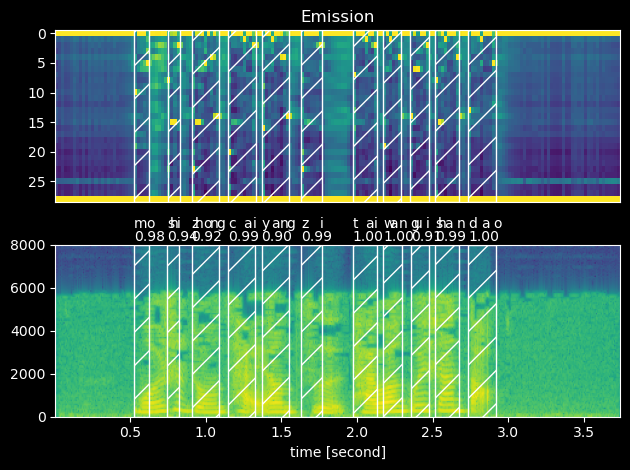

In [22]:
plot_alignments(waveform16k, token_spans, emission, transcript)
print("Raw Transcript: ", raw_text)
print("Normalized Transcript: ", transcript)
IPython.display.Audio(waveform16k, rate=16000)


In [23]:
preview_word(waveform16k, token_spans[0], num_frames, transcript[0])

mo (0.98): 0.523 - 0.624 sec


In [24]:
preview_word(waveform16k, token_spans[1], num_frames, transcript[1])

shi (0.94): 0.745 - 0.825 sec


In [24]:
def get_words(waveform, spans, num_frames, transcript, sample_rate=bundle.sample_rate):
  words = []

  for span, word in zip(spans, transcript):
    ratio = waveform.size(1) / num_frames
    x0 = int(ratio * span[0].start)
    x1 = int(ratio * span[-1].end)
    # print(f"{word} ({_score(span):.2f}): {x0 / sample_rate:.3f} - {x1 / sample_rate:.3f} sec")
    segment = waveform[:, x0:x1]

    words.append(segment.numpy())
  
  return words


In [25]:
get_words(waveform16k, token_spans, num_frames, transcript)

[array([[ 0.0008602 ,  0.00152547,  0.00146088, ..., -0.12834494,
         -0.17637731, -0.21712922]], dtype=float32),
 array([[0.05190656, 0.0598904 , 0.07408149, ..., 0.03356873, 0.03668607,
         0.04070076]], dtype=float32),
 array([[0.0181216 , 0.01834476, 0.01048384, ..., 0.02646755, 0.03330116,
         0.04097961]], dtype=float32),
 array([[-0.00456466, -0.00209737, -0.00218755, ...,  0.05800441,
          0.05843846,  0.05498751]], dtype=float32),
 array([[-0.01578683, -0.00539359,  0.00030392, ..., -0.03163794,
         -0.04327597, -0.05283451]], dtype=float32),
 array([[ 0.00092188,  0.00112764,  0.00146424, ...,  0.02488283,
          0.00154205, -0.03782079]], dtype=float32),
 array([[-0.00292676, -0.00162197, -0.00289358, ..., -0.17404167,
         -0.16074258, -0.14482822]], dtype=float32),
 array([[-0.06909257, -0.08633623, -0.09417263, ..., -0.0747348 ,
         -0.0637566 , -0.05508458]], dtype=float32),
 array([[-0.02763853, -0.02779888, -0.02619934, ..., -0.0338

In [28]:
def get_words(waveform, spans, num_frames) -> List[np.ndarray]:
  words = []

  for span in spans:
    ratio = waveform.size(1) / num_frames
    x0 = int(ratio * span[0].start)
    x1 = int(ratio * span[-1].end)
    segment = waveform[:, x0:x1]

    words.append(segment)
  
  return words

In [29]:
def driver(path, sentence):
  raw_text = re.sub(r'[^\w]', '', sentence)
  transcript = lazy_pinyin(raw_text)

  waveform48k, sample_rate = torchaudio.load(LARGE_MP3_DIR / path)

  resampler = T.Resample(orig_freq=48000, new_freq=16000)
  waveform16k = resampler(waveform48k[0:1])

  emission, token_spans = compute_alignments(waveform16k, transcript)
  num_frames = emission.size(1)

  words = get_words(waveform16k, token_spans, num_frames)

  return words
 

In [35]:
df.shape

(600247, 13)

In [36]:
samll = df[:100]

In [37]:
samll['segmented_audio'] = samll.progress_apply(lambda row: driver(row['path'], row['sentence']), axis=1)

Processing data: 100%|██████████| 100/100 [00:36<00:00,  2.74it/s]
/var/folders/mz/73jxv48x3tb6l6wc7_wvd7t00000gn/T/ipykernel_26215/807193021.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samll['segmented_audio'] = samll.progress_apply(lambda row: driver(row['path'], row['sentence']), axis=1)


In [39]:
from utils.data_processing import breakdown_pinyin

In [40]:
samll['pinyin_breakdown'] = samll['sentence'].progress_apply(breakdown_pinyin)

Processing data: 100%|██████████| 100/100 [00:00<00:00, 1942.20it/s]
/var/folders/mz/73jxv48x3tb6l6wc7_wvd7t00000gn/T/ipykernel_26215/844437691.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samll['pinyin_breakdown'] = samll['sentence'].progress_apply(breakdown_pinyin)


In [42]:
samll['character'] = samll['sentence'].apply(lambda row: [char for char in re.sub(r'[^\w]', '', row)])

/var/folders/mz/73jxv48x3tb6l6wc7_wvd7t00000gn/T/ipykernel_26215/3264336854.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samll['character'] = samll['sentence'].apply(lambda row: [char for char in re.sub(r'[^\w]', '', row)])


In [46]:
len(samll['segmented_audio'][0]) == len(samll['pinyin_breakdown'][0])

True

In [47]:
mask = samll.apply(lambda row: len(row['character']) == len(row['pinyin_breakdown']), axis=1)

In [50]:
samll.explode(['segmented_audio', 'character', 'pinyin_breakdown'], ignore_index=True)

,client_id,path,sentence_id,sentence,sentence_domain,up_votes,down_votes,age,gender,accents,variant,locale,segment,segmented_audio,pinyin_breakdown,character
0,25bc975d06200b7b1c9135db090561cb0d9b28d172e51c...,common_voice_zh-CN_19703883.mp3,33bf426e7162122b062710c1aee44949efea3fef159bbb...,模式种采样自台湾龟山岛。,NaN,1,0,thirties,female_feminine,出生地：31 上海市,NaN,zh-CN,NaN,"[[tensor(0.0009), tensor(0.0015), tensor(0.001...","(m, o, 2)",模
1,25bc975d06200b7b1c9135db090561cb0d9b28d172e51c...,common_voice_zh-CN_19703883.mp3,33bf426e7162122b062710c1aee44949efea3fef159bbb...,模式种采样自台湾龟山岛。,NaN,1,0,thirties,female_feminine,出生地：31 上海市,NaN,zh-CN,NaN,"[[tensor(0.0519), tensor(0.0599), tensor(0.074...","(sh, i, 4)",式
2,25bc975d06200b7b1c9135db090561cb0d9b28d172e51c...,common_voice_zh-CN_19703883.mp3,33bf426e7162122b062710c1aee44949efea3fef159bbb...,模式种采样自台湾龟山岛。,NaN,1,0,thirties,female_feminine,出生地：31 上海市,NaN,zh-CN,NaN,"[[tensor(0.0181), tensor(0.0183), tensor(0.010...","(zh, ong, 3)",种
3,25bc975d06200b7b1c9135db090561cb0d9b28d172e51c...,common_voice_zh-CN_19703883.mp3,33bf426e7162122b062710c1aee44949efea3fef159bbb...,模式种采样自台湾龟山岛。,NaN,1,0,thirties,female_feminine,出生地：31 上海市,NaN,zh-CN,NaN,"[[tensor(-0.0046), tensor(-0.0021), tensor(-0....","(c, ai, 3)",采
4,25bc975d06200b7b1c9135db090561cb0d9b28d172e51c...,common_voice_zh-CN_19703883.mp3,33bf426e7162122b062710c1aee44949efea3fef159bbb...,模式种采样自台湾龟山岛。,NaN,1,0,thirties,female_feminine,出生地：31 上海市,NaN,zh-CN,NaN,"[[tensor(-0.0158), tensor(-0.0054), tensor(0.0...","(EMPTY, iang, 4)",样
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1626,56d138a29f7850e806c48289e68a284506907d6d3ff2d7...,common_voice_zh-CN_22050256.mp3,60d9a59e86d5fec6814ab4eba0f29734973ed4980cd838...,会面导致穆夫提被巴基斯坦一个宗教委员会停职。,NaN,0,0,thirties,male_masculine,出生地：22 吉林省,NaN,zh-CN,NaN,"[[tensor(-0.0174), tensor(-0.0240), tensor(-0....","(EMPTY, uei, 3)",委
1627,56d138a29f7850e806c48289e68a284506907d6d3ff2d7...,common_voice_zh-CN_22050256.mp3,60d9a59e86d5fec6814ab4eba0f29734973ed4980cd838...,会面导致穆夫提被巴基斯坦一个宗教委员会停职。,NaN,0,0,thirties,male_masculine,出生地：22 吉林省,NaN,zh-CN,NaN,"[[tensor(-0.0063), tensor(-0.0415), tensor(-0....","(EMPTY, van, 2)",员
1628,56d138a29f7850e806c48289e68a284506907d6d3ff2d7...,common_voice_zh-CN_22050256.mp3,60d9a59e86d5fec6814ab4eba0f29734973ed4980cd838...,会面导致穆夫提被巴基斯坦一个宗教委员会停职。,NaN,0,0,thirties,male_masculine,出生地：22 吉林省,NaN,zh-CN,NaN,"[[tensor(0.0217), tensor(0.0189), tensor(0.014...","(h, uei, 4)",会
1629,56d138a29f7850e806c48289e68a284506907d6d3ff2d7...,common_voice_zh-CN_22050256.mp3,60d9a59e86d5fec6814ab4eba0f29734973ed4980cd838...,会面导致穆夫提被巴基斯坦一个宗教委员会停职。,NaN,0,0,thirties,male_masculine,出生地：22 吉林省,NaN,zh-CN,NaN,"[[tensor(0.0009), tensor(-0.0043), tensor(-0.0...","(t, ing, 2)",停


In [54]:
samll[['path', 'sentence']].to_records(index=False).tolist()

[('common_voice_zh-CN_19703883.mp3', '模式种采样自台湾龟山岛。'),
 ('common_voice_zh-CN_19706151.mp3', '后者娶天之瓮主神。'),
 ('common_voice_zh-CN_19961025.mp3', '贝尔卢。'),
 ('common_voice_zh-CN_20051292.mp3', '日本与东帝汶的关系可追溯至第二次世界大战期间。'),
 ('common_voice_zh-CN_20051309.mp3', '单县各乡镇设有卫生院或医院。'),
 ('common_voice_zh-CN_20070076.mp3', '尤里二世当下便决定要在该地点建造大基捷日城。'),
 ('common_voice_zh-CN_20070223.mp3', '毛山鼠李为鼠李科鼠李属下的一个变种。'),
 ('common_voice_zh-CN_20070263.mp3', '遂吸收众多渴望消灾除难的人入道。'),
 ('common_voice_zh-CN_20070488.mp3', '毛山鼠李为鼠李科鼠李属下的一个变种。'),
 ('common_voice_zh-CN_20163037.mp3', '这项研究旨在了解一个地区的空间结构和性质。'),
 ('common_voice_zh-CN_20163057.mp3', '驯养的沙特瞪羚的基因分析显示它们有可能是不同的物种或混种。'),
 ('common_voice_zh-CN_20220279.mp3', '后其家移居台湾台北市。'),
 ('common_voice_zh-CN_20359866.mp3', '本条目记载了有关日本的妖怪。'),
 ('common_voice_zh-CN_20359996.mp3', '阿丽安萝德中扮演了其最重要的角色。'),
 ('common_voice_zh-CN_20391561.mp3', '格里梅尔斯豪森是德国图林根州的一个市镇。'),
 ('common_voice_zh-CN_20391684.mp3', '厌食症确诊的必要条件为明显过低的体重。'),
 ('common_voice_zh-CN_20409535.mp3', '请勿摄影、饮食、吸烟'),
 ('common